In [1]:
from requests import get
from bs4 import BeautifulSoup
from scipy.optimize import minimize
import numpy as np
from matplotlib import pyplot as plt
from collections import OrderedDict

In [2]:
import yaml

try:
    from yaml import CLoader as Loader, CDumper as Dumper
except ImportError:
    from yaml import Loader, Dumper

class flowmap( dict ): pass
def flowmap_rep(dumper, data):
    return dumper.represent_mapping( u'tag:yaml.org,2002:map', data, flow_style=True)

class blockseqtrue( list ): pass
def blockseqtrue_rep(dumper, data):
    return dumper.represent_sequence( u'tag:yaml.org,2002:seq', data, flow_style=True )

yaml.add_representer(blockseqtrue, blockseqtrue_rep)
yaml.add_representer(flowmap, flowmap_rep)

class MyDumper(yaml.Dumper):
    def write_line_break(self, data=None):
        super().write_line_break(data)
        if len(self.indents) == 1:
            super().write_line_break()

In [3]:
def get_response(url):
    return get(url).content

In [4]:
def get_html_table(Name):

    # We treat the url attaching the Name variable to it.
    url = str.format('https://webbook.nist.gov/cgi/cbook.cgi?Name={0}&Mask=4',
        Name.lower())

    # Function to get the request made, see above.
    raw_html = get_response(url)

    # Parse the html using BeautifulSoup.
    html = BeautifulSoup(raw_html, 'html.parser')

    # Extract the table that contains the data, the table has a specific
    # attributes 'aria-label' as 'Antoine Equation Parameters'.
    table = html.find('table', attrs={'aria-label': 'Antoine Equation Parameters'})

    return table

In [9]:
Name = "CH4"


In [14]:
def nist_thermo(Name):
    url = str.format('https://webbook.nist.gov/cgi/cbook.cgi?Formula={0}&Mask=1#Thermo-Gas',
            Name.lower())
    raw_html = get_response(url)
    html = BeautifulSoup(raw_html, 'html.parser')
    if "Name Not Found" in html.text:
        raise Exception('Did not find it')
    
    if 'Click on the name to see more data' in html.text:
        lst = html.find_all('ol')[0].find_all('li')
        ii = -1
        for i in range(len(lst)):
            ind = lst[i].text.index('(')
            if lst[i].text[ind:].replace('(','').replace(')','').strip() == Name:
                ii = i

                break
        if ii == -1:
            raise Exception('Did not find it')
        new_url = "https://webbook.nist.gov"+lst[ii].find_all('a')[0]['href']
        raw_html = get_response(new_url)
        html = BeautifulSoup(raw_html, 'html.parser')
    
    table = html.find('table', attrs={'aria-label': 'Gas Phase Heat Capacity (Shomate Equation)'})
    order = ['Temperature (K)','A','B','C','D','E','F','G','H','Reference','Comment']
    p_labels = ['A','B','C','D','E','F','G','H']

    for i in range(len(order)):
        assert table.find_all('tr')[i].find_all('th')[0].text == order[i]

    ncol = len(table.find_all('tr')[0].find_all('td'))

    Tlow = []
    Thigh = []
    for j in range(ncol):
        tmp = table.find_all('tr')[0].find_all('td')[j].text
        low = float(tmp.replace(' ','').split('-')[0])
        high = float(tmp.replace(' ','').split('-')[1])
        Tlow.append(low)
        Thigh.append(high)

    Tranges = []
    for i in range(len(Tlow)+1):
        if i == 0:
            Tranges.append(Tlow[i])
        elif i == len(Tlow):
            Tranges.append(Thigh[-1])
        else:
            assert Tlow[i] == Thigh[i-1]
            Tranges.append(Tlow[i])

    params = []
    for j in range(ncol):
        temp = []
        for i in range(len(p_labels)):
            temp.append(float(table.find_all('tr')[i+1].find_all('td')[j].text))
        params.append(temp)
    out = {}
    out['model'] = 'Shomate'
    out['temperature-ranges'] = Tranges
    out['data'] = params
    return out

In [16]:
Name = 'HCN'
nist_thermo(Name)

Exception: Did not find it

In [181]:
new_url

'https://webbook.nist.gov/cgi/cbook.cgi?ID=C3315375&Units=SI&Mask=1'

In [178]:
new_url

'https://webbook.nist.gov/cgi/cbook.cgi?ID=C3315375&Units=SI&Mask=1'

In [138]:
html.find_all('ol')[0].find_all('li')[0].find_all('a')

[<a href="/cgi/cbook.cgi?ID=C3315375&amp;Units=SI&amp;Mask=1">Methylidyne</a>]

'(CH)'

In [18]:
import cirpy
cirpy.resolve('CH4', 'smiles')

In [22]:
cirpy.resolve('hydrogen cyanide', 'cas')

['191234-22-7', '341972-31-4', '74-90-8']

In [58]:
tmp = table.find_all('tr')[0].find_all('td')[0].text

In [68]:
low = float(tmp.replace(' ','').split('-')[0])
high = float(tmp.replace(' ','').split('-')[1])

In [73]:
Thigh

[1300.0, 6000.0]

In [5]:
def get_antoine_coef(Name):
    # Obtaining the table using the get_html function showed below. Table is a
    # BeautifulSoup Object.
    table = get_html_table(Name)

    # Extract the rows from the table. Knowing what tags have an HTML table.
    # Also, knowing that the fist row with he table header does not have the
    # class attribute 'exp' so we obtain just the rows with data.
    # The find_all function from BeautifulSoup return a list
    rows = table.find_all('tr', class_='exp')

    # Declaring the lists for storage Temperatures, and coefficients.
    Temperatures, As, Bs, Cs = [], [], [], []

    # Looping over rows to extract and fill As, Bs, and Cs variables because now
    # we are sure the Temperatues is between some range.
    for row in rows:

        # As the rows, we extract the columns for the current row. Knowing that
        # the cols have the <td> tag in HTML as well
        # The find_all function from BeautifulSoup return a list
        cols =  row.find_all('td')

        # First transform the strings into float numbers and put them in their
        # respective list
        As.append(float(cols[1].text))
        Bs.append(float(cols[2].text))
        Cs.append(float(cols[3].text))

        # For the temperatures, we have a range and we need to extract each
        # limit (lower and higher) and put them in an extra list. So
        # Temperatures variable will be a list of lists.
        lower_lim = float(cols[0].text.replace(" ","").split('-')[0])
        higher_lim = float(cols[0].text.replace(" ","").split('-')[1])
        Temperatures.append([lower_lim, higher_lim])

        return As,Bs,Cs,Temperatures

In [12]:
fil = open('../reaction_mechanisms/zahnle_earth.yaml','r')
zahnle = yaml.load(fil,Loader=Loader)
fil.close()

In [13]:
comp = {}
for i in range(len(zahnle['species'])):
    comp[zahnle['species'][i]['name']] = zahnle['species'][i]['composition']

In [56]:
for i in range(len(zahnle['species'])):
    if 'C' in zahnle['species'][i]['name'] \
    and "H" in zahnle['species'][i]['name'] \
    and not 'Cl' in zahnle['species'][i]['name'] \
    and not 'O' in zahnle['species'][i]['name']:
        print(zahnle['species'][i]['name'])

CH
CH2
CH3
CH4
HCN
C2H
C2H2
C2H4
C2H6
C3H4
C3H6
C4H2
C4H4
HCS
C2H3
C2H5
1CH2
H2CN
C4H
C4H3
CH2N2
CH2CN
CH3CN
HCCCN


In [6]:
name = 'OCS'
As,Bs,Cs,Ts = get_antoine_coef(name)
comp[name]

AttributeError: 'NoneType' object has no attribute 'find_all'

In [119]:
Ts

[[90.99, 189.99]]

In [120]:
i = 0
Aa = As[i]
Ba = Bs[i]
Ca = Cs[i]

In [121]:
T = np.linspace(70,300,100)

def antoine(A,B,C,T):
    return 10**(A - B/(C+T))

def sat(A,B,C,T):
    return np.exp(A + B/T + C/T**2)

def objective(x):
    A,B,C = x
    return np.linalg.norm(np.log10(antoine(Aa,Ba,Ca,T)) - np.log10(sat(A,B,C,T)))

sol = minimize(objective,[9,-1,1])
A,B,C = sol.x
# sol

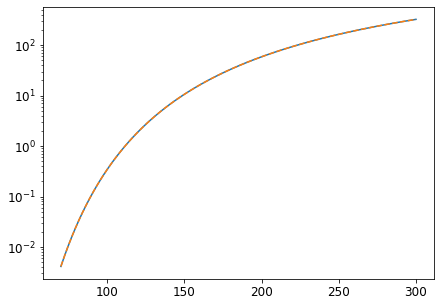

In [122]:
plt.rcParams.update({'font.size': 12})
fig,ax = plt.subplots(1,1,figsize=[7,5])

ax.plot(T,antoine(Aa,Ba,Ca,T))

ax.plot(T,sat(A,B,C,T),'--')

ax.set_yscale('log')

In [116]:
res = {}
res['name'] = name+'aer'
res['formation'] = "saturation"
res['density'] = 1
res['gas-phase'] = name
res['saturation-parameters'] = {"A":float('%.2e'%A),"B":float('%.2e'%B),"C":float('%.2e'%C)}
res['composition'] = comp[name]
res['optical-properties'] = "khare1984"
res['optical-type'] = 'mie'

res['saturation-parameters'] = flowmap(res['saturation-parameters'])
res['composition'] = flowmap(res['composition'])



In [117]:

fil = open('saturation_data.yaml','r')
data = yaml.load(fil,Loader=Loader)
fil.close()



data.append(res)
for i in range(len(data)):
    data[i]['saturation-parameters'] = flowmap(data[i]['saturation-parameters'])
    data[i]['composition'] = flowmap(data[i]['composition'])

# data = [res]
fil = open('saturation_data.yaml','w')
yaml.dump(data,fil,Dumper=MyDumper,sort_keys=False,width=70)
fil.close()


In [19]:
Temperatures

[[214.64, 308.33], [192.59, 206.3]]

In [20]:
As

[4.66141, 4.19598]

In [21]:
Bs

[909.079, 699.53]

In [22]:
Cs

[7.947, -21.47]